In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import glob
from functools import reduce
from scipy.stats import mannwhitneyu
import itertools
import matplotlib.pyplot as plt
from statannot import add_stat_annotation
from math import log
from statsmodels import stats
from statsmodels.stats import multitest
import rpy2.robjects as robjects
from collections import defaultdict
import os,sys
import plotly.express as px
import plotly.graph_objects as go
import plotly
from openpyxl import load_workbook

In [2]:
def setPlotFont(fig):
    fig = fig.update_layout(font=dict(size=12,family='Arial',color="black"))
    return fig

In [3]:
metGroups = {'biomass' : 'Biomass',
             'acetate' : 'SCFAs', 'Formate' : 'SCFAs','propionate' : 'SCFAs','butyrate' : 'SCFAs',
            'L-tryptophan' : 'Amino acid',
            'L-cysteine' : 'Amino acid',
            'L-serine' : 'Amino acid',
            'Glycine' : 'Amino acid',
            'L-leucine' : 'Amino acid',
            'L-valine' : 'Amino acid',
            'L-proline' : 'Amino acid',
            'L-isoleucine' : 'Amino acid',
            'L-alanine' : 'Amino acid',
            'L-methionine' : 'Amino acid',
            'L-histidine' : 'Amino acid',
            'L-cystine' : 'Amino acid',
            'L-glutamate(1-)' : 'Amino acid',
            'starch, structure 2 (1,6-{2[1,4-Glc], [1,4-Glc]})' : 'Carbohydrate',
            'L-phenylalanine' : 'Amino acid',
            'Sucrose': 'Carbohydrate',
            'L-threonine' : 'Amino acid',
            'L-aspartate(1-)' : 'Amino acid',
            'L-tyrosine' : 'Amino acid',
            'Hexadecanoate (n-C16:0)' : 'Lipid',
            'octadecenoate (n-C18:1)' : 'Lipid',
            'tetradecanoate (n-C14:0)' : 'Lipid',
            'Hexadecanoate (n-C16:0)': 'Lipid',
            'octadecanoate (n-C18:0)': 'Lipid',
            'laurate': 'Lipid',
            'tetradecanoate (n-C14:0)': 'Lipid',
            'octadecenoate (n-C18:1)': 'Lipid'}

# METEOR

We mapped raw sequence data against a gene catalog of mouse gut metagenome using METEOR. We check then the % mapped reads and throw out outliers. Then we used momr to build species dataframe

### Meteor mapping, gene counts and species counts

In [47]:
mapped = pd.read_csv('data/counting_report.csv')
fig = px.bar(mapped,x='sample',y='read_count',template='none',color_discrete_sequence=['black'])
fig = setPlotFont(fig)
fig.update_layout(autosize=False,width=450,height=300)
fig.update_xaxes(title='',tickangle=270,nticks=len(set(mapped['sample'])))
#fig.write_image('Figures/metagenomics/mapping_count.pdf')
fig.show()
#sns.barplot(data=mapped,x='sample',y='%mapped_read_count')

In [51]:
taxo[taxo['genus'] == 'Eubacterium']

,species,genus,order,phylum
mgs,,,,
MmMGS:0031,Eubacterium siraeum,Eubacterium,Clostridiales,Firmicutes
MmMGS:0194,Eubacterium siraeum,Eubacterium,Clostridiales,Firmicutes
MmMGS:0216,Eubacterium eligens,Eubacterium,Clostridiales,Firmicutes
MmMGS:0217,Erysipelotrichaceae bacterium 5_2_54FAA,Eubacterium,Erysipelotrichales,Firmicutes
MmMGS:0269,Eubacterium siraeum,Eubacterium,Clostridiales,Firmicutes
MmMGS:0331,Eubacterium ventriosum,Eubacterium,Clostridiales,Firmicutes
MmMGS:0456,Eubacterium ventriosum,Eubacterium,Clostridiales,Firmicutes


In [175]:
fig = px.box(mapped,y='%mapped_read_count',template='none',color_discrete_sequence=['black'])
fig = setPlotFont(fig)
fig.update_layout(autosize=False,width=300,height=300)
fig.update_xaxes(title='',tickangle=270,nticks=len(set(mapped['sample'])))
fig.write_image('Figures/metagenomics/mapping_rate_box.pdf')
fig.show()

In [474]:
gene_counts = pd.read_csv('data/merged_final.csv',sep='\t',index_col=0)
gene_counts = gene_counts.drop(columns=['HCC121', 'HCC125'])

In [6]:
mgs = pd.read_csv('data/mgs_final.csv',index_col=0)
sums = pd.DataFrame()
for col in mgs.columns:
    sums.at[col,'GeneCount'] = mgs[col].sum()

In [476]:
sums = pd.DataFrame()
for col in gene_counts.columns:
    sums.at[col,'GeneCount'] = gene_counts[col].sum()

## IMPORT

In [3]:
mgs = pd.read_csv('data/mgs_final.csv',index_col=0)
taxo = pd.read_csv('data/taxo.csv',index_col=0)
metadata = pd.read_csv('data/metadata.csv',index_col=0)
metadata = metadata.drop(index=['HCC121', 'HCC125'])
metadata['Group'] = metadata['Experiment'] + '_' + metadata['Feeding']

In [4]:
mgs.head(3)

,HCC101,HCC102,HCC103,HCC104,HCC105,HCC106,HCC107,HCC108,HCC109,HCC110,...,HCC115,HCC116,HCC117,HCC118,HCC119,HCC120,HCC122,HCC123,HCC124,HCC126
MmMGS:0004,0.000007,0.000002,0.000002,0.000003,0.000006,0.000001,0.000003,0.000003,0.000003,0.000003,...,3.282712e-07,1.796209e-07,0.0,0.0,0.0,0.0,0.000003,0.000005,2.094095e-06,0.000003
MmMGS:0011,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000
MmMGS:0012,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.000000,0.000000,2.567772e-08,0.000000


## DIVERSITY

In [10]:
def shannon(df):
    import pandas as pd
    from skbio.diversity.alpha import shannon
    df = pd.DataFrame(df.agg(shannon, axis=1), columns=['Shannon Diversity Index'])
    return df

def richness(df):
    import pandas as pd
    import numpy as np
    df = pd.DataFrame(df.agg(np.count_nonzero, axis=1), columns=['Richness'])
    return df

In [26]:
df = shannon(mgs.T)
df.T.head()

,HCC101,HCC102,HCC103,HCC104,HCC105,HCC106,HCC107,HCC108,HCC109,HCC110,...,HCC115,HCC116,HCC117,HCC118,HCC119,HCC120,HCC122,HCC123,HCC124,HCC126
Shannon Diversity Index,4.63634,5.481351,5.10112,5.271956,3.974317,5.051054,5.123139,4.872795,5.423705,5.49054,...,4.246433,4.937312,4.592894,4.978,4.651463,5.121389,5.035178,4.358658,4.96374,4.998123


No significance within Group


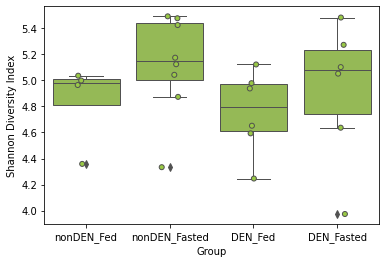

In [27]:
x = 'Group'
Gorder=['nonDEN_Fed','nonDEN_Fasted','DEN_Fed','DEN_Fasted']
for row in set(df.T.index):
    df = df.T.loc[[row], :]
    df.loc['sum'] = df.sum(axis=0)
    df = df.drop(index=row)
    df = df.rename(index={'sum':row})
    df = df.T
    plotdf = df.join(metadata,how='outer')
    fix, ax = plt.subplots(1,1)
    fig = sns.boxplot(data=plotdf, y=row, x=x, linewidth=1, ax=ax,order=Gorder,color='#99c945')
    fig = sns.stripplot(data=plotdf, y=row, x=x, linewidth=1, ax=ax,order=Gorder,color='#99c945')
    box_pairs = itertools.combinations(metadata[x].unique(),2)
    pvalues= {}
    for pair in box_pairs:
        data1 = plotdf.groupby(x)[row].get_group(pair[0])
        data2 = plotdf.groupby(x)[row].get_group(pair[1])
        stat, p = mannwhitneyu(data1, data2)
        pvalues[pair] = p
    pvals = pd.Series(pvalues)
    fdr = pd.Series(multitest.multipletests(pvals,method='fdr_bh')[1])
    pvals = pvals.replace(dict(zip(pvals.values,fdr.values)))
    sigpvals = pvals.loc[pvals < 0.05]
    if len(sigpvals > 0):
        ax, test_results = add_stat_annotation(
            ax,
            box_pairs=sigpvals.index,
            data=plotdf,
            x=x,
            y=row,
            order=Gorder,
            perform_stat_test=False,
            pvalues=sigpvals,
            test_short_name='M.W.W',
            text_format='full',
            #loc='outside',
            verbose=2)
    else:
        print(f'No significance within {x}')

## Clustering

In [21]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
#import numpy as np
import skbio
from scipy.spatial import distance
import plotly.express as px

In [32]:
def PCOA(df):
    df = df.loc[:, df.sum() != 0]
    Ar_dist = distance.squareform(distance.pdist(df, metric="braycurtis"))
    DM_dist = skbio.stats.distance.DistanceMatrix(Ar_dist)
    PCoA = skbio.stats.ordination.pcoa(DM_dist, number_of_dimensions=2)
    results = PCoA.samples.copy()
    df['PC1'], df['PC2'] = results.iloc[:,0].values, results.iloc[:,1].values
    return df,Ar_dist

In [34]:
df = PCOA(mgs.T)[0]
d = []
for index,row in df.iterrows():
    d.append({'Sample' : index,
              'PC1' : row['PC1'],
              'PC2' : row['PC2'],
              'Group' : metadata.at[index,'Group']})
toPlot = pd.DataFrame(d)

In [30]:
fig = px.scatter(toPlot,x='PC1',y='PC2',color='Group',template='none')
fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                              selector=dict(mode='markers'))
fig.show()

### Metagenomics analysis

In [7]:
mgs_sub = mgs.rename(index=dict(zip(taxo.index,taxo.phylum)))
mgs_final = pd.DataFrame(columns=mgs_sub.columns)
for row in set(mgs_sub.index):
    df = mgs_sub.loc[[row], :]
    df.loc['sum'] = df.sum(axis=0)
    df = df.drop(index=row)
    df = df.rename(index={'sum':row})
    mgs_final = mgs_final.append(df)
for group in set(metadata['Experiment']):
    mgs_final[group] = mgs_final[metadata[metadata['Group'] == group].index.tolist()].mean(axis=1)
mgs_final = mgs_final.drop(metadata.index,axis=1)

In [8]:
mgs_final.head()

,DEN,nonDEN
Bacteroidetes,NaN,NaN
Verrucomicrobia,NaN,NaN
Proteobacteria,NaN,NaN
Firmicutes,NaN,NaN
Actinobacteria,NaN,NaN


In [96]:
d = []
for group in set(metadata['Group']):
    df = mgs_final.sort_values(by=group,ascending=False)
    df[group] = df[group] / df[group].sum()
    df = df.head(n=20)
    for index,row in df.iterrows():
        d.append({'Group' : group,'Rel. abundance' : row[group],'Species' : index})
toPlot = pd.DataFrame(d)

In [138]:
toPlot2 = toPlot[toPlot['Species'] == 'Verrucomicrobia']
fig = px.bar(toPlot,x='Group',y='Rel. abundance',color='Species',template='none',
             color_discrete_sequence=px.colors.qualitative.Vivid,
             category_orders={"Group": ["nonDEN_Fed", "nonDEN_Fasted",'DEN_Fed','DEN_Fasted']})
fig.update_layout(autosize=False,height=400,width=300,margin=dict(l=50,b=100,t=50,r=50,pad=4))
fig = setPlotFont(fig)
fig.update_xaxes(title='',tickangle=270)
#fig.write_image('Figures/metagenomics/rel_abundance_phylum.pdf')
fig.show()

In [139]:
px.colors.qualitative.Vivid

['rgb(229, 134, 6)',
 'rgb(93, 105, 177)',
 'rgb(82, 188, 163)',
 'rgb(153, 201, 69)',
 'rgb(204, 97, 176)',
 'rgb(36, 121, 108)',
 'rgb(218, 165, 27)',
 'rgb(47, 138, 196)',
 'rgb(118, 78, 159)',
 'rgb(237, 100, 90)',
 'rgb(165, 170, 153)']

In [573]:
topSpecies = list(set(toPlot.Species))

In [168]:
combs = [['nonDEN_Fed','nonDEN_Fasted'],['nonDEN_Fasted','DEN_Fed'],['DEN_Fed','DEN_Fasted']]
fout = open('sankey_network.sif','w')
for comb in combs:
    for species in top[comb[0]]:
        if species in top[comb[1]]:
            fout.write(comb[0]+'_'+species+'\tmr\t'+comb[1]+'_'+species+'\n')
fout.close()

At this stage we selected the top species from AGORA models for each of the conditions. In some instances the species were not available then we choose on genus level or in other instances there are strain level models then we take all of them

#### Taxonomy level statistics

In [22]:
# Different taxe set here
mgs_sub = mgs.rename(index=dict(zip(taxo.index,taxo.species)))
mgs_sub.head()

,HCC101,HCC102,HCC103,HCC104,HCC105,HCC106,HCC107,HCC108,HCC109,HCC110,...,HCC115,HCC116,HCC117,HCC118,HCC119,HCC120,HCC122,HCC123,HCC124,HCC126
Tannerella sp. 6_1_58FAA_CT1,0.000007,0.000002,0.000002,0.000003,0.000006,0.000001,2.910536e-06,3.053847e-06,0.000003,0.000003,...,3.282712e-07,1.796209e-07,0.0,0.0,0.0,0.0,3.366570e-06,0.000005,2.094095e-06,2.640305e-06
Roseburia intestinalis,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
Marvinbryantia formatexigens,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,2.567772e-08,0.000000e+00
Clostridium phytofermentans,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.936574e-08,9.926070e-08,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
Marvinbryantia formatexigens,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,9.072502e-07,0.000000,0.000000e+00,1.022197e-07


No significance within Experiment
No significance within Experiment
No significance within Experiment
No significance within Experiment
No significance within Experiment
No significance within Experiment
No significance within Experiment
No significance within Experiment
No significance within Experiment
DEN v.s. nonDEN: Custom statistical test, P_val:2.856e-03
DEN v.s. nonDEN: Custom statistical test, P_val:4.846e-02
No significance within Experiment
No significance within Experiment
No significance within Experiment
DEN v.s. nonDEN: Custom statistical test, P_val:3.669e-02
DEN v.s. nonDEN: Custom statistical test, P_val:1.202e-02
No significance within Experiment
No significance within Experiment
No significance within Experiment
No significance within Experiment
DEN v.s. nonDEN: Custom statistical test, P_val:2.016e-02


/var/folders/zc/h_66z5bx601_njjc__92xndnxk18rv/T/ipykernel_51176/1641626785.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fix, ax = plt.subplots(1,1)


No significance within Experiment
No significance within Experiment
No significance within Experiment
No significance within Experiment
No significance within Experiment
No significance within Experiment
No significance within Experiment
No significance within Experiment
DEN v.s. nonDEN: Custom statistical test, P_val:4.040e-02
DEN v.s. nonDEN: Custom statistical test, P_val:1.084e-03
No significance within Experiment
No significance within Experiment
No significance within Experiment
No significance within Experiment
No significance within Experiment
No significance within Experiment
No significance within Experiment
No significance within Experiment
DEN v.s. nonDEN: Custom statistical test, P_val:4.992e-02
No significance within Experiment
No significance within Experiment
No significance within Experiment
No significance within Experiment
No significance within Experiment


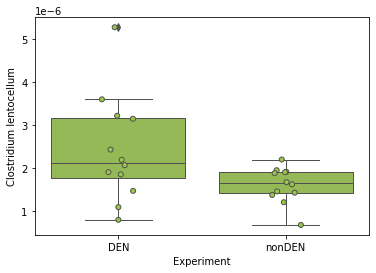

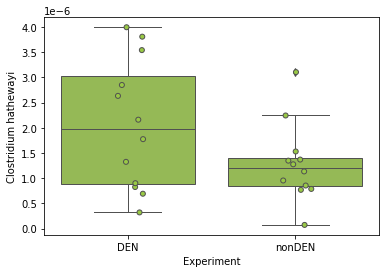

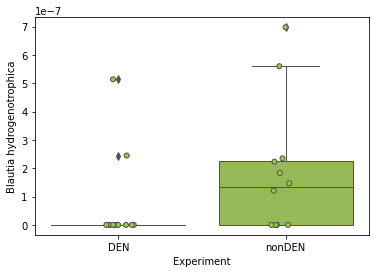

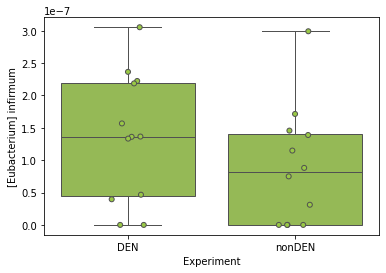

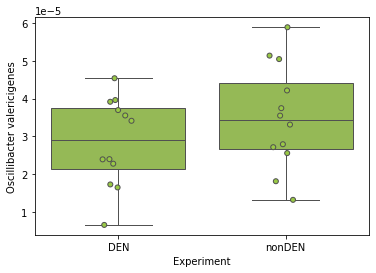

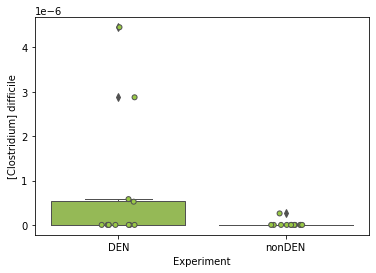

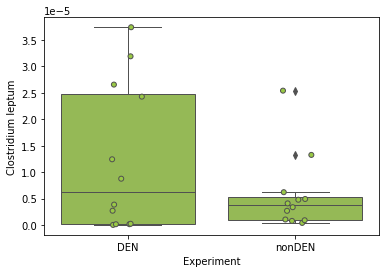

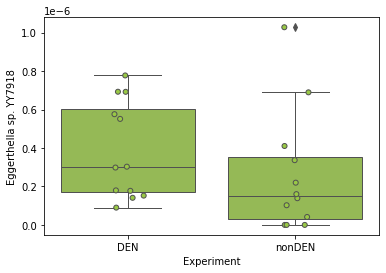

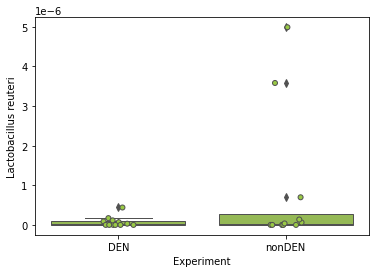

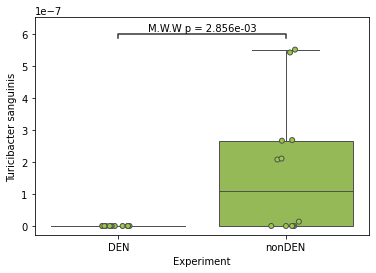

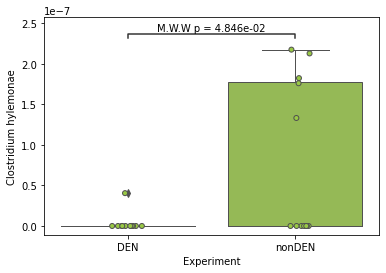

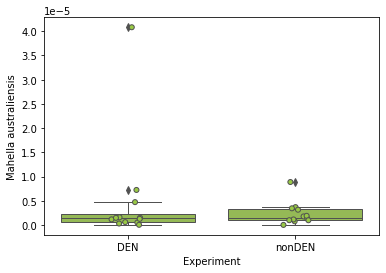

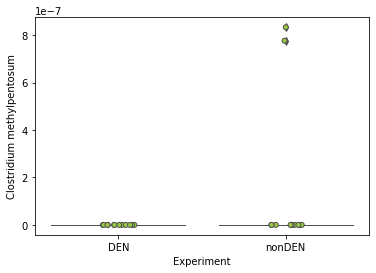

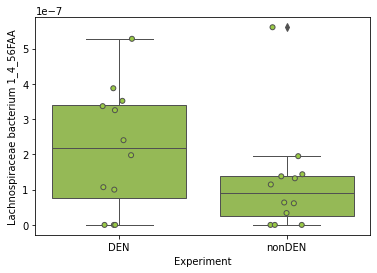

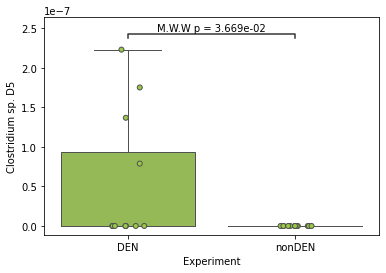

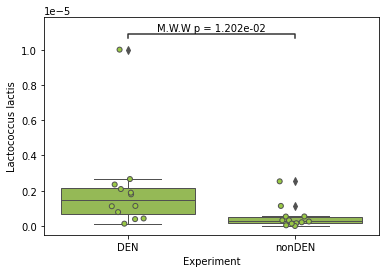

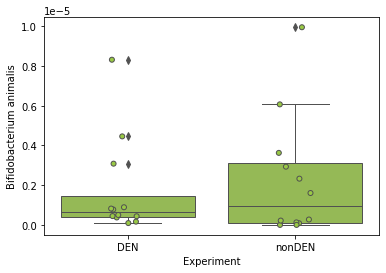

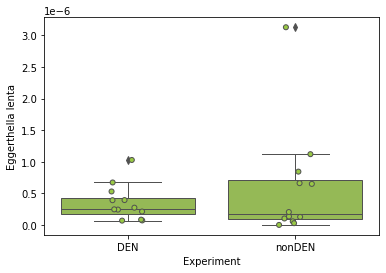

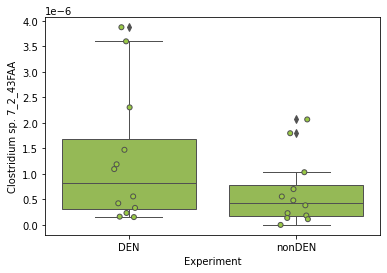

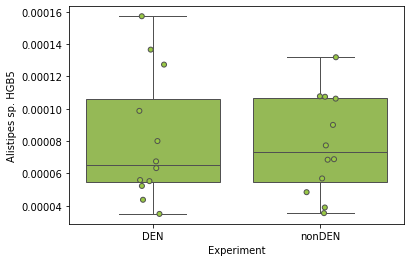

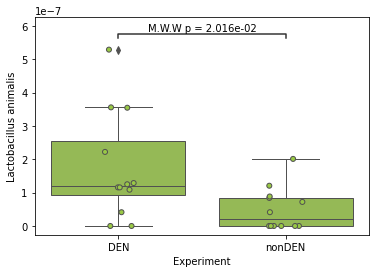

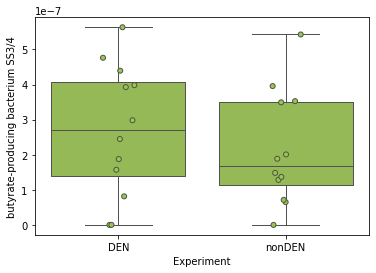

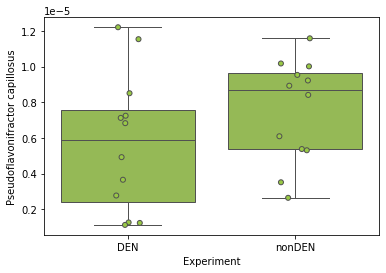

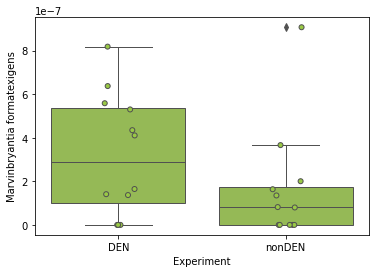

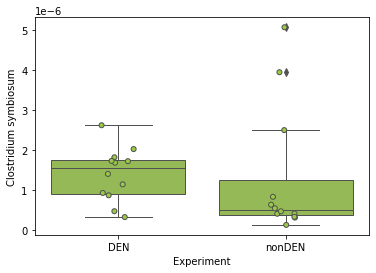

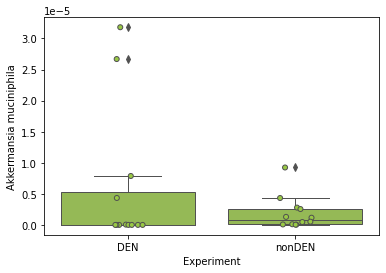

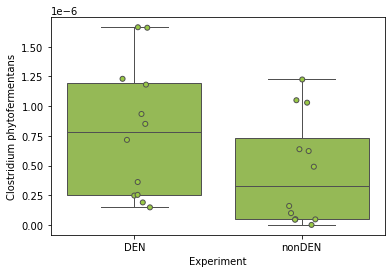

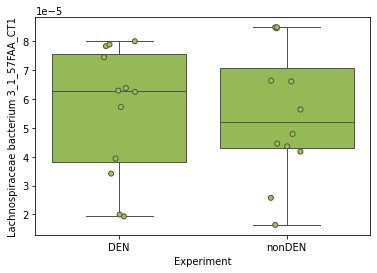

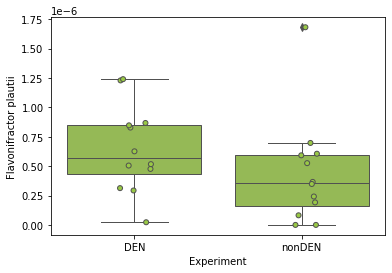

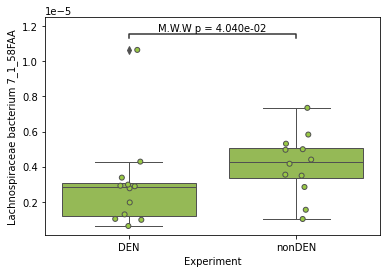

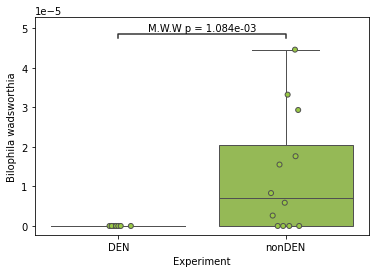

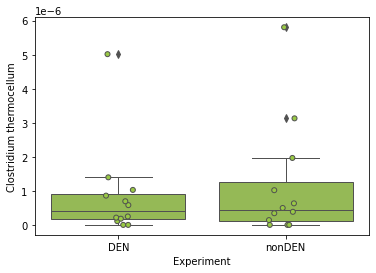

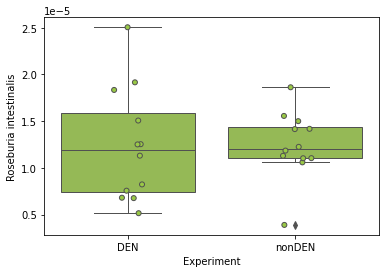

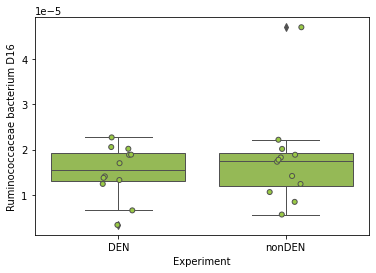

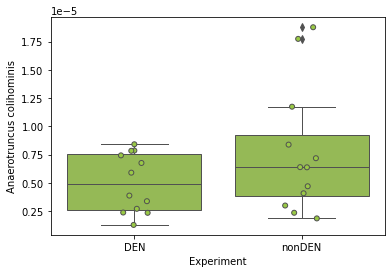

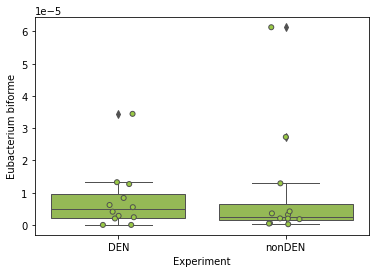

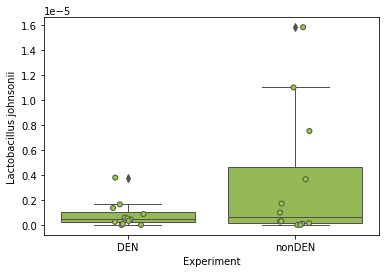

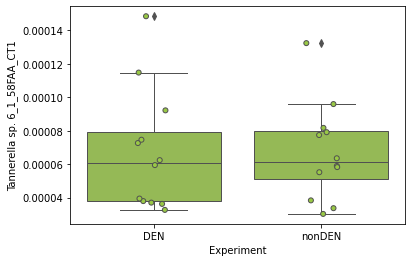

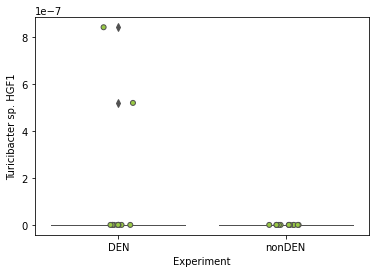

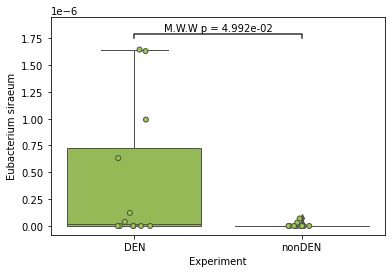

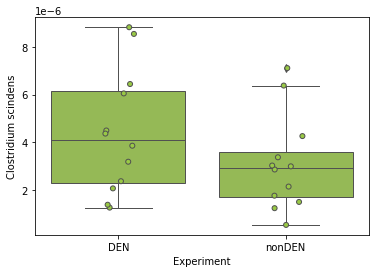

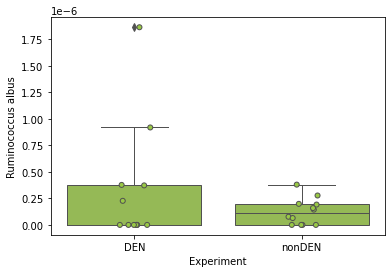

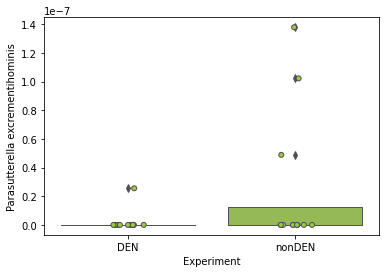

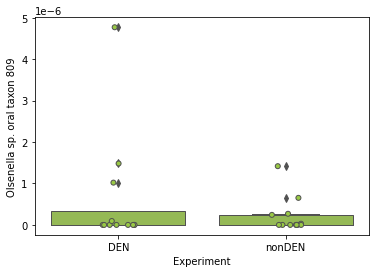

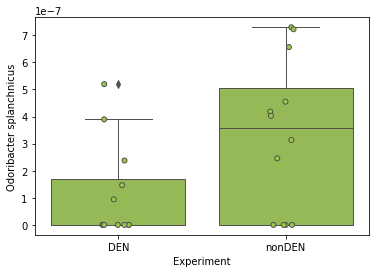

In [15]:
x = 'Experiment'
Gorder=['nonDEN_Fed','nonDEN_Fasted','DEN_Fed','DEN_Fasted']
Gorder=['DEN','nonDEN']
#Gorder=['Fed','Fasted']
for row in set(mgs_sub.index):
    df = mgs_sub.loc[[row], :]
    df.loc['sum'] = df.sum(axis=0)
    df = df.drop(index=row)
    df = df.rename(index={'sum':row})
    df = df.T
    plotdf = df.join(metadata,how='outer')
    fix, ax = plt.subplots(1,1)
    fig = sns.boxplot(data=plotdf, y=row, x=x, linewidth=1, ax=ax,order=Gorder,color='#99c945')
    fig = sns.stripplot(data=plotdf, y=row, x=x, linewidth=1, ax=ax,order=Gorder,color='#99c945')
    box_pairs = itertools.combinations(metadata[x].unique(),2)
    pvalues= {}
    for pair in box_pairs:
        data1 = plotdf.groupby(x)[row].get_group(pair[0])
        data2 = plotdf.groupby(x)[row].get_group(pair[1])
        stat, p = mannwhitneyu(data1, data2)
        pvalues[pair] = p
    pvals = pd.Series(pvalues)
    fdr = pd.Series(multitest.multipletests(pvals,method='fdr_bh')[1])
    pvals = pvals.replace(dict(zip(pvals.values,fdr.values)))
    sigpvals = pvals.loc[pvals < 0.05]
    if len(sigpvals > 0):
        ax, test_results = add_stat_annotation(
            ax,
            box_pairs=sigpvals.index,
            data=plotdf,
            x=x,
            y=row,
            order=Gorder,
            perform_stat_test=False,
            pvalues=sigpvals,
            test_short_name='M.W.W',
            text_format='full',
            #loc='outside',
            verbose=2)
    else:
        print(f'No significance within {x}')
    #fix.savefig('Figures/phylum/'+row.replace('/','')+'.pdf')
#    if row in topSpecies:
#        fix.savefig('Figures/modelling_species/'+row.replace('/','')+'.pdf')

# FLUX VISUALISATION

In [4]:
def addCarbonFluxes(df,mets):
    metnames = dict(zip(METS['metName'],METS['metFormula']))
    for index,row in df.iterrows():
        composition = metnames[row['Compound']]
        df.at[index,'Composition'] = composition
        try:
            carbon = float(composition.split('H')[0].replace('C','').strip())
        except (ValueError,AttributeError):
            if row['Compound'] == 'Formate':
                carbon == 1
            else:
                carbon = 0
        df.at[index,'Carbon flux'] = row['Flux (mmol/mouse/day)'] * carbon
    return df
        
def getBiomassCmoles(df,diets,experiments):
    d = {}
    for diet in diets:
        for experiment in experiments:
            sub_df = df[(df['Diet'] == diet) & (df['Experiment'] == experiment)]
            IN = sub_df[sub_df['Direction'] == 'Consumption']
            cmoles_in = abs(IN['Carbon flux'].sum())
            OUT = sub_df[sub_df['Direction'] == 'Production']
            cmoles_out = abs(OUT['Carbon flux'].sum())
            biomass = cmoles_in - cmoles_out
            idx = df.index[(df['Diet'] == diet) & (df['Experiment'] == experiment) & (df['Compound'] == 'biomass')].tolist()
            df.at[idx,'Carbon flux'] = biomass
    return df

Read in flux sheets for WD and CD

In [10]:
experiments = ['nonDEN_Fed','nonDEN_Fasted','DEN_Fed','DEN_Fasted']
diets = ['WD','CD','WDCARBS','WDLIPIDS','WDAA','WDAACARBS','WDAALIPIDS','WDCARBSLIPIDS']
diets = ['WD','CD']
path = 'data/models/Fluxes/'
FLUXES = defaultdict(dict)
for diet in diets:
    for experiment in experiments:
        FLUXES[diet][experiment] = pd.read_excel(path+'Fluxes'+diet+'.xlsx',sheet_name=experiment,index_col=0)
        FLUXES[diet][experiment].at['EX_3hppnl','EQUATION'] = '3-Hydroxypropanal[e] <=> '
        FLUXES[diet][experiment] = FLUXES[diet][experiment].rename(index={'community_biomass': 'EX_biomass'})

Plot a single reactions flux

In [301]:
for diet in diets:
    for experiment in experiments:
        for index,row in FLUXES[diet][experiment].iterrows():
            if str(row['EQUATION']) == 'nan':
                print(index)

In [311]:
query_rxn = 'EX_ac(e)'

In [312]:
d = []
for diet in FLUXES:
    for experiment in FLUXES[diet]:
        d.append({'Experiment' : experiment,
                  'Diet' : diet,
                  'Flux' : FLUXES[diet][experiment].at[query_rxn,'FLUX']})
toPlot = pd.DataFrame(d)

In [313]:
fig = px.bar(toPlot,x='Experiment',y='Flux',color='Experiment',template='none',facet_col='Diet')
fig.show()

Plot exchange reactions

In [11]:
d = []
for diet in FLUXES:
    for experiment in FLUXES[diet]:
        flux = FLUXES[diet][experiment]
        flux = flux[abs(flux['FLUX']) > 0.01]
        flux = flux[flux.index.str.contains("EX_")]
        for index,row in flux.iterrows():
            compound = str(row['EQUATION']).replace('[e]','').strip()
            compound = compound.replace('=>','').strip()
            compound = compound.replace(' <','').strip()
            if row['FLUX'] > 0:
                player = 'Production'
            else:
                player = 'Consumption'
            if compound in metGroups:
                group = metGroups[compound]
            else:
                group = 'Other'
            d.append({'Diet' : diet,'Experiment' : experiment,'Compound' : compound, 'Group' : group,
                      'Direction' : player, 'Flux (mmol/mouse/day)' : row['FLUX']})

In [12]:
METS = pd.read_csv('data/models/METS.csv')
toPlot = pd.DataFrame(d)
#toPlot = toPlot[toPlot['Flux'] > 0]
#toPlot = toPlot[~toPlot['Compound'].isin(['acetate','Formate','propionate','butyrate'])]
toPlot = toPlot.sort_values(by=['Flux (mmol/mouse/day)'])
toPlot = addCarbonFluxes(toPlot,METS)
toPlot = getBiomassCmoles(toPlot,diets,experiments)
toPlot['Diet_Experiment'] = toPlot['Diet'] + '_' + toPlot['Experiment']
toPlot['FluxGroup'] = np.where(toPlot['Carbon flux'].abs() <= 1,'Low',toPlot['Compound'])
toPlot.head()

,Diet,Experiment,Compound,Group,Direction,Flux (mmol/mouse/day),Composition,Carbon flux,Diet_Experiment,FluxGroup
123,WD,DEN_Fed,Sucrose,Carbohydrate,Consumption,-2.984045,C12H22O11,-35.808534,WD_DEN_Fed,Sucrose
174,WD,DEN_Fasted,Sucrose,Carbohydrate,Consumption,-2.984045,C12H22O11,-35.808534,WD_DEN_Fasted,Sucrose
71,WD,nonDEN_Fasted,Sucrose,Carbohydrate,Consumption,-2.984045,C12H22O11,-35.808534,WD_nonDEN_Fasted,Sucrose
27,WD,nonDEN_Fed,Sucrose,Carbohydrate,Consumption,-2.984045,C12H22O11,-35.808534,WD_nonDEN_Fed,Sucrose
289,CD,nonDEN_Fasted,"starch, structure 2 (1,6-{2[1,4-Glc], [1,4-Glc]})",Carbohydrate,Consumption,-2.587562,C18H32O16,-46.576116,CD_nonDEN_Fasted,"starch, structure 2 (1,6-{2[1,4-Glc], [1,4-Glc]})"


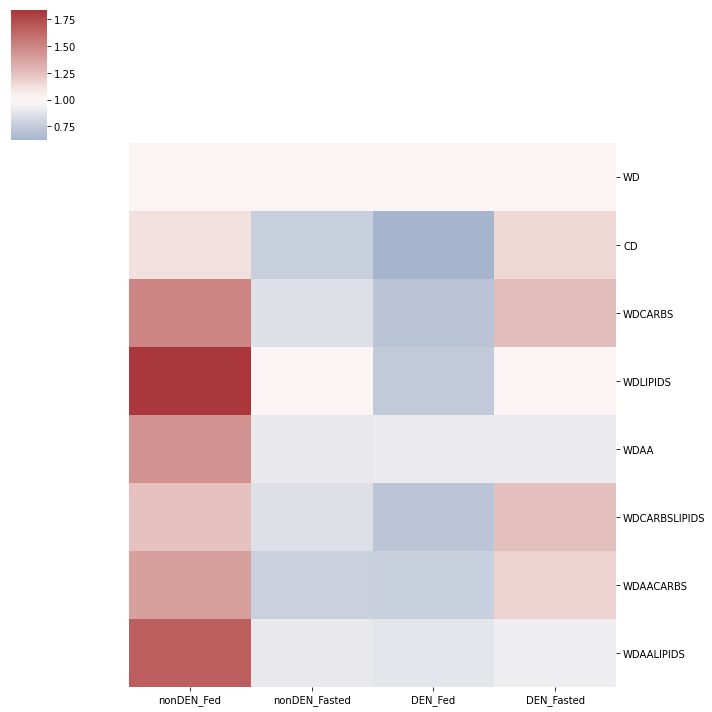

In [347]:
df = toPlot[toPlot['Compound'] == 'biomass']
norm_df = df[df['Diet'] == 'WD']
norm = dict(zip(norm_df['Experiment'] , norm_df['Carbon flux']))
x = ['nonDEN_Fed','nonDEN_Fasted','DEN_Fed','DEN_Fasted']
y = ['WD','CD','WDCARBS','WDLIPIDS','WDAA','WDCARBSLIPIDS','WDAACARBS','WDAALIPIDS']

outdf = pd.DataFrame(index=y,columns=x)
for index,row in df.iterrows():
    outdf.at[row['Diet'],row['Experiment']] = row['Carbon flux'] / norm[row['Experiment']]
outdf = outdf.astype('float')
fig = sns.clustermap(outdf,row_cluster=False,col_cluster=False,cmap="vlag",center=1)  
fig.savefig('Figures/fluxes/sydicos_biomass.pdf')

Plot the entire uptake intake distribution

In [220]:
fig = px.bar(toPlot,
             x='Compound',
             y='Flux (mmol/mouse/day)',
             color='Experiment',
             facet_col='Diet',
             facet_row='Experiment',
             template='none')
fig.update_layout(autosize=False,width=1500,height=1000,margin=dict(l=50,b=300,t=50,r=50,pad=4))
fig.update_xaxes(nticks=len(set(toPlot.Compound)),title='',tickangle=270)
fig = setPlotFont(fig)
fig.show()

Focus on consumption or production

In [18]:
toPlot

,Diet,Experiment,Compound,Group,Direction,Flux (mmol/mouse/day),Composition,Carbon flux,Diet_Experiment,FluxGroup
123,WD,DEN_Fed,Sucrose,Carbohydrate,Consumption,-2.984045,C12H22O11,-35.808534,WD_DEN_Fed,Sucrose
174,WD,DEN_Fasted,Sucrose,Carbohydrate,Consumption,-2.984045,C12H22O11,-35.808534,WD_DEN_Fasted,Sucrose
71,WD,nonDEN_Fasted,Sucrose,Carbohydrate,Consumption,-2.984045,C12H22O11,-35.808534,WD_nonDEN_Fasted,Sucrose
27,WD,nonDEN_Fed,Sucrose,Carbohydrate,Consumption,-2.984045,C12H22O11,-35.808534,WD_nonDEN_Fed,Sucrose
289,CD,nonDEN_Fasted,"starch, structure 2 (1,6-{2[1,4-Glc], [1,4-Glc]})",Carbohydrate,Consumption,-2.587562,C18H32O16,-46.576116,CD_nonDEN_Fasted,"starch, structure 2 (1,6-{2[1,4-Glc], [1,4-Glc]})"
...,...,...,...,...,...,...,...,...,...,...
148,WD,DEN_Fasted,acetate,SCFAs,Production,19.568411,C2H3O2,39.136823,WD_DEN_Fasted,acetate
254,CD,nonDEN_Fasted,Formate,SCFAs,Production,22.730325,CH1O2,45.460649,CD_nonDEN_Fasted,Formate
207,CD,nonDEN_Fed,Formate,SCFAs,Production,26.492564,CH1O2,52.985127,CD_nonDEN_Fed,Formate
304,CD,DEN_Fed,Formate,SCFAs,Production,27.449113,CH1O2,54.898226,CD_DEN_Fed,Formate


In [20]:
production = toPlot[toPlot['Direction'] == 'Production']
#production['Carbon flux'] = production['Carbon flux'].apply(lambda x: x*-1)
cols = plotly.colors.qualitative.Pastel[0:7] 
#production = production[production['Group'] == 'Other']
#production = production[production['Group'].isin(['Carbohydrate','Lipid','Amino acid'])]
fig = px.bar(production,
             x='Diet_Experiment',
             y='Carbon flux',
             color='Group',
             #facet_col='Diet',
             template='none',
             #color_discrete_sequence=px.colors.qualitative.G10,
             #color_discrete_sequence=[cols[1],cols[2],cols[3],cols[6]],
             color_discrete_sequence=['black','grey','lightgrey'],
             category_orders={"Diet_Experiment": ["CD_Diet","WD_Diet",
                                                  "CD_nonDEN_Fed","CD_nonDEN_Fasted",'CD_DEN_Fed','CD_DEN_Fasted',
                                                  "WD_nonDEN_Fed","WD_nonDEN_Fasted",'WD_DEN_Fed','WD_DEN_Fasted'],
                              #"Group" : ['Carbohydrate','Lipid', 'Amino acid', 'Other'],
                              #"Group" : ['Biomass','SCFAs', 'Other'],
                              #"Compound" : ['propionate','Formate','butyrate','acetate'],
                              "Diet" : ['CD','WD']})
fig.update_layout(autosize=False,width=400,height=400,margin=dict(l=50,b=150,t=50,r=50,pad=4))
fig.update_layout(legend_traceorder="reversed")
fig.update_xaxes(title='',tickangle=270)
fig.update_yaxes(range=[0,122.91450475284728])
fig = setPlotFont(fig)
#fig.write_image('Figures/fluxes/uptake.pdf')
fig.show()

In [25]:
(34.22665 + 54.89823) / 122.914505

0.725096521358484

In [23]:
production.groupby('Diet_Experiment').sum() 

,Flux (mmol/mouse/day),Carbon flux
Diet_Experiment,,
CD_DEN_Fasted,39.500914,120.934802
CD_DEN_Fed,40.964524,122.914505
CD_nonDEN_Fasted,40.829778,122.415164
CD_nonDEN_Fed,40.413365,122.645755
WD_DEN_Fasted,32.541264,107.648109
WD_DEN_Fed,32.276005,108.712999
WD_nonDEN_Fasted,32.115522,107.336593
WD_nonDEN_Fed,31.948478,107.703219


## SyDiCoS

In [326]:
def generateHeatmapData(WT,MUTS,index):
    x = ['nonDEN_Fed','nonDEN_Fasted','DEN_Fed','DEN_Fasted']
    y = list(MUTS.keys())
    outdf = pd.DataFrame(index=y,columns=x)
    for row in y:
        for col in x:
            ratio = MUTS[row][col].at[index,'FLUX'] / WT[col].at[index,'FLUX']
            outdf.at[row,col] = ratio
    outdf = outdf.astype('float')
    fig = sns.clustermap(outdf,row_cluster=False,col_cluster=False,cmap="vlag",center=1)
    return fig

In [325]:
path = 'data/models/Fluxes/'
experiments = ['nonDEN_Fed','nonDEN_Fasted','DEN_Fed','DEN_Fasted']
component = {'All' : 'FluxesCD.xlsx',
             'Carbs' : 'FluxesWDCARBS.xlsx',
             'Lipids' : 'FluxesWDLIPIDS.xlsx',
             'AAs' : 'FluxesWDAA.xlsx',
             'CarbsLipids' : 'FluxesWDCARBSLIPIDS.xlsx',
             'AAsCarbs' : 'FluxesWDAACARBS.xlsx',
             'AAsLipids' : 'FluxesWDAALIPIDS.xlsx'}

WT = {}
for exp in experiments:
    WT[exp] = pd.read_excel(path+'FluxesWD.xlsx',sheet_name=exp,index_col=0)

component_d = defaultdict(dict)
for sheet in component:
    print(sheet)
    for exp in experiments:
        df = pd.read_excel(path+component[sheet],sheet_name=exp,index_col='ID')
        #df = df.rename(index={'community_biomass': 'EX_biomass'})
        component_d[sheet][exp] = df

All
Carbs
Lipids
AAs
CarbsLipids
AAsCarbs
AAsLipids


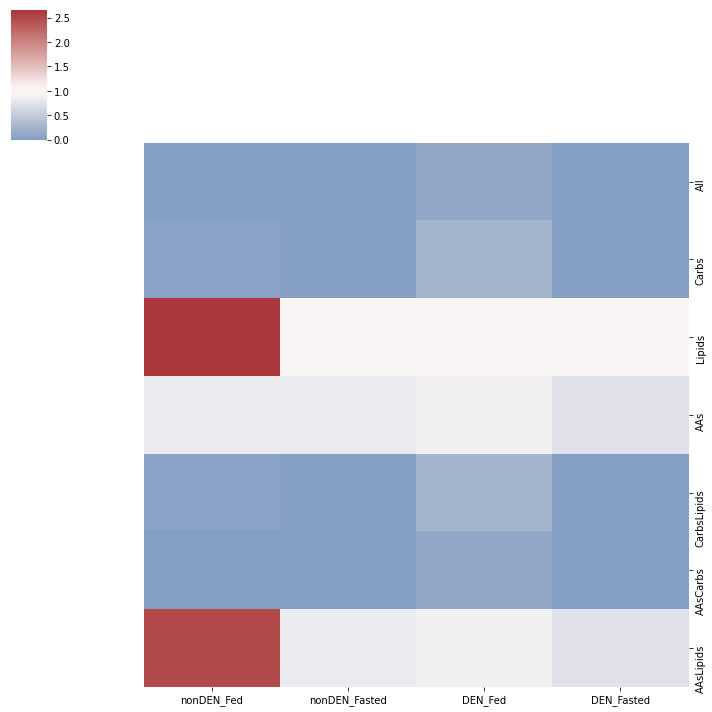

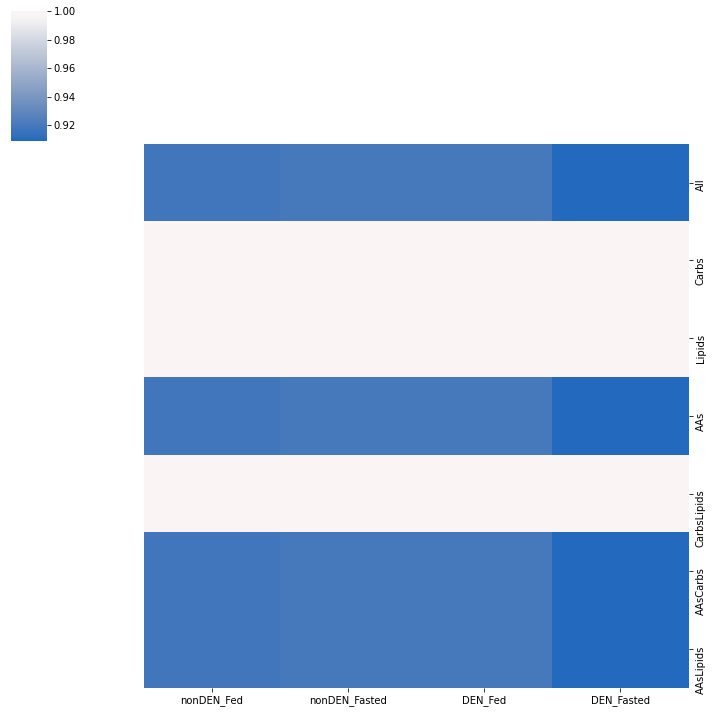

In [327]:
fig = generateHeatmapData(WT,component_d,'EX_glyc(e)')
fig.savefig('Figures/fluxes/sydicos_glycerol.pdf')
fig = generateHeatmapData(WT,component_d,'community_biomass')
fig.savefig('Figures/fluxes/sydicos_biomass.pdf')

In order to understand which bacteria are responsible for glycerol production we removed each species systematically and then perform FBA with each KO

In [26]:
import mat73

In [27]:
matlab_struct = mat73.loadmat('speciesKO.mat')

ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
ERROR:root:ERROR: MATLAB type not supported: string, (uint32)


In [28]:
mat_contents = matlab_struct['speciesKO']
mat_contents['diet'] = ['WD','WD','WD','WD','CD','CD','CD','CD']

In [29]:
def getWildType(FLUXES,queryRxn,diets,experiments):
    wild_type = defaultdict(dict)
    for diet in diets:
        for experiment in experiments:
            wild_type[diet][experiment] = FLUXES[diet][experiment].at[queryRxn,'FLUX']
    return wild_type

In [62]:
query_rxn = 'EX_biomass'
query_diets = ['WD','CD']
query_experiments = ['nonDEN_Fed','nonDEN_Fasted','DEN_Fed','DEN_Fasted']

In [69]:
wild_type_fluxes = getWildType(FLUXES,query_rxn,query_diets,query_experiments)
wild_type_fluxes

defaultdict(dict,
            {'WD': {'nonDEN_Fed': 1.1759371273352428,
              'nonDEN_Fasted': 1.1768121006386916,
              'DEN_Fed': 1.1804452575897468,
              'DEN_Fasted': 0.9849676930147769},
             'CD': {'nonDEN_Fed': 1.0798281672584578,
              'nonDEN_Fasted': 1.0817208598971197,
              'DEN_Fed': 1.0853844244240247,
              'DEN_Fasted': 0.8954475420206415}})

In [70]:
counter = 0
df = pd.DataFrame()
while counter < len(mat_contents['KO']):
    if mat_contents['diet'][counter] in query_diets and mat_contents['modelname'][counter] in query_experiments:
        diet = mat_contents['diet'][counter]
        modelname = mat_contents['modelname'][counter]
        speciesKO = mat_contents['KO'][counter]
        print(mat_contents['diet'][counter] + '\t' + mat_contents['modelname'][counter])
        species_count = 0
        for species in speciesKO['species']:
            #rxns = [x[0] for x in (speciesKO['rxns'][species_count])]
            rxns = list(FLUXES[diet][modelname].index)
            flux = speciesKO['flux'][species_count][rxns.index(query_rxn)]
            normalised_flux = flux / wild_type_fluxes[diet][modelname]
            df.at[species,diet+'_'+modelname] = normalised_flux
            species_count += 1
    counter += 1

WD	nonDEN_Fed
WD	nonDEN_Fasted
WD	DEN_Fed
WD	DEN_Fasted
CD	nonDEN_Fed
CD	nonDEN_Fasted
CD	DEN_Fed
CD	DEN_Fasted


In [71]:
df = df.sort_values(by=['WD_nonDEN_Fed'],ascending=False)
df = df[['CD_nonDEN_Fed',
         'CD_nonDEN_Fasted',
         'CD_DEN_Fed',
         'CD_DEN_Fasted',
         'WD_nonDEN_Fed',
         'WD_nonDEN_Fasted',
         'WD_DEN_Fed',
         'WD_DEN_Fasted']]
#df = df.apply(lambda x: np.log10(x) if np.issubdtype(x.dtype, np.number) else x)
df.head(10)

,CD_nonDEN_Fed,CD_nonDEN_Fasted,CD_DEN_Fed,CD_DEN_Fasted,WD_nonDEN_Fed,WD_nonDEN_Fasted,WD_DEN_Fed,WD_DEN_Fasted
Lachnospiraceae_bacterium_sp_8_1_57FAA,1.040227,1.032512,1.037686,1.044074,1.036849,1.029822,0.000000,1.039975
Ruminococcaceae_bacterium_D16,1.037152,1.027284,1.024227,1.034400,1.033739,1.025093,1.022289,1.031164
Lachnospiraceae_bacterium_sp_5_1_63FAA,1.023816,1.029813,1.022774,1.022980,1.021860,1.027377,1.020953,1.020786
Roseburia_intestinalis_L1_82,1.022082,1.020935,1.015538,1.031601,1.020275,1.019230,1.014297,1.028620
Eubacterium_biforme_DSM_3989,1.016261,1.002654,1.007310,1.004653,1.014934,1.002446,1.006718,1.004221
Anaerotruncus_colihominis_DSM_17241,1.005836,1.003844,1.002657,1.003387,1.005359,1.003496,1.002445,1.003077
Alistipes_putredinis_DSM_17216,1.004899,1.010014,1.009165,1.012653,1.004314,1.009218,1.008440,1.011416
Pseudoflavonifractor_capillosus_strain_ATCC_29799,1.004165,1.007168,1.003151,1.005918,1.003825,1.006590,0.000000,1.005368
Clostridium_symbiosum_WAL_14163,1.002114,NaN,1.001140,1.001660,1.001940,NaN,1.001054,1.001484
Clostridium_symbiosum_WAL_14673,1.002083,NaN,1.001103,1.001600,1.001920,NaN,1.001027,1.001430


In [72]:
def createHeatmap(df):
    x = df.index
    y = list(df.columns)
    z = []
    for i in x:
        l = []
        for j in y:
            l.append(df.at[i,j])
        z.append(l)
    #for index,row in df.iterrows():
    #    #x.append(index)
    #    l = []
    #    for col in y:
    #        l.append(row[col])
    #    z.append(l)
    fig = go.Figure(data=go.Heatmap(z=z,x=y,y=x,
                                    colorscale=[(0, "blue"),(0.97,"white"),(1, 'red')],reversescale=False))
    fig.update_layout(template = 'none',title='',xaxis_nticks=0,yaxis_nticks=0,plot_bgcolor='#777777',
                      autosize=False,width=600,height=800,
                      margin=dict(l=300,r=50,b=100,t=50,pad=4),
                      font=dict(size=10,family='Arial',color="black"))
    fig.update_xaxes(showticklabels=True,tickangle=90)
    return [fig,x]

In [74]:
fig,x = createHeatmap(df)
fig.show()
fig.write_image('Figures/fluxes/biomass_ko.pdf')

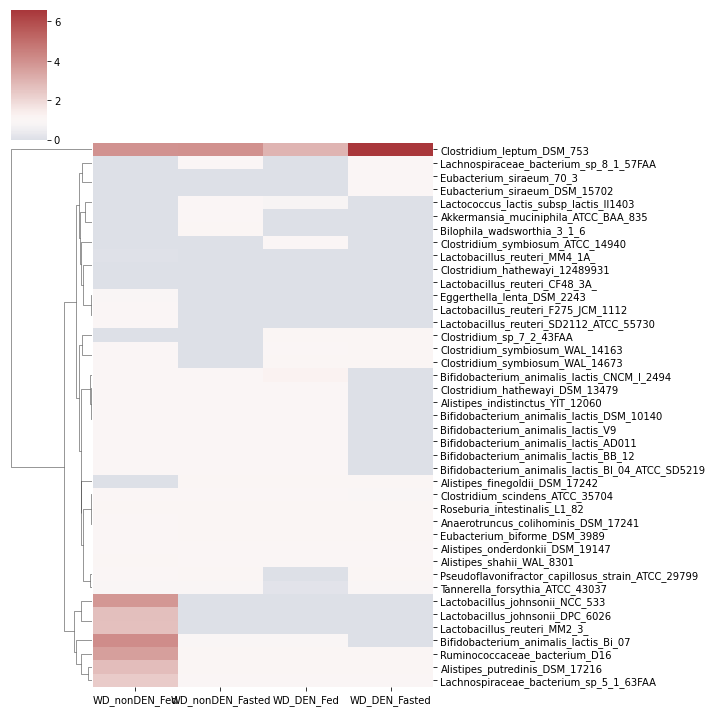

In [88]:
df = df.fillna(0)
sns.clustermap(df,cmap="vlag",center=1,col_cluster=False,yticklabels=True)